In [1]:
!pip install torchview
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.1 MB/s eta 0:00:00a 0:00:01


# **Sexist Classification with BERT Embeddings using Multi-task Convolutional Neural Network**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import Adam
from torcheval.metrics import MulticlassAccuracy, MulticlassF1Score
from sklearn.metrics import classification_report
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

import os
datadir = '/kaggle/input/new-edos/data_6'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEVELS = np.array(['1', '2', '3', '3_1', '3_2', '3_3', '3_4'])
BATCH_SIZE = 16

In [2]:
torch.tensor([1.0, 1.5, 2.0, 2.0, 2.0, 2.0, 2.0]).to(device) / 7

tensor([0.1429, 0.2143, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857])

## **Load Data**

In [3]:
train = pd.read_csv(os.path.join(datadir, 'train.csv'))
dev = pd.read_csv(os.path.join(datadir, 'dev.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

In [4]:
ALL_LABELS = []
for i in range(len(LEVELS)):
    ALL_LABELS.append(np.array(sorted(train[f'label_{LEVELS[i]}'].unique().tolist())))
ALL_LABELS = np.array(ALL_LABELS, dtype=object)
ALL_LABELS

array([array(['not sexist', 'sexist'], dtype='<U10'),
       array(['1. threats, plans to harm and incitement', '2. derogation',
              '3. animosity', '4. prejudiced discussions', 'not sexist'],
             dtype='<U40')                                                ,
       array(['1.1 threats of harm', '1.2 incitement and encouragement of harm',
              '2.1 descriptive attacks', '2.2 aggressive and emotive attacks',
              '2.3 dehumanising attacks & overt sexual objectification',
              '3.1 casual use of gendered slurs, profanities, and insults',
              '3.2 immutable gender differences and gender stereotypes',
              '3.3 backhanded gendered compliments',
              '3.4 condescending explanations or unwelcome advice',
              '4.1 supporting mistreatment of individual women',
              '4.2 supporting systemic discrimination against women as a group',
              'not sexist'], dtype='<U63')                              

In [5]:
def label_to_idx(label, level):
    return ALL_LABELS[level-1].tolist().index(label)

def idx_to_label(idx, level):
    return ALL_LABELS[level-1][idx]

label_to_idx('not sexist', 2), idx_to_label(0, 4)

(4, '1.1 threats of harm')

In [6]:
y_trains = []
for i in range(len(LEVELS)):
    y_trains.append(train[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)))
    y_trains[i] = torch.nn.functional.one_hot(torch.tensor(y_trains[i]), num_classes=ALL_LABELS[i].shape[0])
    print(y_trains[i].shape)

torch.Size([14000, 2])
torch.Size([14000, 5])
torch.Size([14000, 12])
torch.Size([14000, 4])
torch.Size([14000, 5])
torch.Size([14000, 6])
torch.Size([14000, 4])


In [7]:
y_devs = []
for i in range(len(LEVELS)):
    y_devs.append(dev[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)))
    y_devs[i] = torch.nn.functional.one_hot(torch.tensor(y_devs[i]), num_classes=ALL_LABELS[i].shape[0])
    print(y_devs[i].shape)

torch.Size([2000, 2])
torch.Size([2000, 5])
torch.Size([2000, 12])
torch.Size([2000, 4])
torch.Size([2000, 5])
torch.Size([2000, 6])
torch.Size([2000, 4])


In [8]:
y_tests = []
for i in range(len(LEVELS)):
    y_tests.append(test[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)))
    y_tests[i] = torch.nn.functional.one_hot(torch.tensor(y_tests[i]), num_classes=ALL_LABELS[i].shape[0])
    print(y_tests[i].shape)

torch.Size([4000, 2])
torch.Size([4000, 5])
torch.Size([4000, 12])
torch.Size([4000, 4])
torch.Size([4000, 5])
torch.Size([4000, 6])
torch.Size([4000, 4])


## **BERT Embeddings**

In [9]:
# model_path = 'distilbert-base-uncased' # local
model_path = 'vinai/bertweet-large' # kaggle

tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_model = AutoModel.from_pretrained(model_path)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model_name = model_path.split('/')[-1]

assert len(model_name.split('/')) == 1
model_name

'bertweet-large'

In [11]:
x_trains = train['text'].tolist()
x_devs = dev['text'].tolist()
x_tests = test['text'].tolist()

### Padding by batch

In [12]:
batches = []

batch_0 = tokenizer(x_trains[:16], padding=True)
batch_0['input_ids'] = torch.tensor(batch_0['input_ids'])
batch_0['attention_mask'] = torch.tensor(batch_0['attention_mask'])
batches.append(batch_0)

# print(batches['input_ids'].shape)

batch_1 = tokenizer(x_trains[16:32], padding=True)
batch_1['input_ids'] = torch.tensor(batch_1['input_ids'])
batch_1['attention_mask'] = torch.tensor(batch_1['attention_mask'])
batches.append(batch_1)

batches[1]['attention_mask'].shape

torch.Size([16, 64])

In [13]:
print(len(x_trains), len(y_trains[0]))

14000 14000


In [14]:
class MiniBatchPaddingDataset(Dataset):
    def __init__(self, x, y, batch_size=BATCH_SIZE):
        self.x = x
        self.y = y
        self.batch_size = batch_size

        # padding by max length in each batch
        self.num_batches = math.ceil(len(self.x) / self.batch_size)

        self.input_ids = []
        self.attention_masks = []
        
        for batch in range(self.num_batches):
            batch_start = batch * self.batch_size
            batch_end = min((batch + 1) * self.batch_size, len(x))

            batch_encodings = tokenizer(self.x[batch_start:batch_end], padding=True)
            batch_input_ids = batch_encodings['input_ids']
            batch_attention_mask = batch_encodings['attention_mask']

            self.input_ids += batch_input_ids
            self.attention_masks += batch_attention_mask
            

    def __getitem__(self, index):
        input_ids = torch.tensor(self.input_ids[index])
        attention_mask = torch.tensor(self.attention_masks[index])
        labels = []

        for i in range(len(LEVELS)):
            labels.append(self.y[i][index])

        # print(input_ids.shape, attention_mask.shape, labels[0].shape, labels[1].shape, labels[2].shape, labels[3].shape, labels[4].shape, labels[5].shape, labels[6].shape)

        return input_ids, attention_mask, labels[0], labels[1], labels[2], labels[3], labels[4], labels[5], labels[6]
    
    def __len__(self):
        return len(self.x)

train_dataset = MiniBatchPaddingDataset(x_trains, y_trains)
dev_dataset = MiniBatchPaddingDataset(x_devs, y_devs)
test_dataset = MiniBatchPaddingDataset(x_tests, y_tests)

### Dataloader

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
for input_ids, attention_mask, label_1, label_2, label_3, label_4, label_5, label_6, label_7 in train_loader:
    print(input_ids.shape)
    print(attention_mask.shape)
    print(label_1.shape)
    print(label_2.shape)
    print(label_3.shape)
    print(label_4.shape)
    print(label_5.shape)
    print(label_6.shape)
    print(label_7.shape)
    
    break

torch.Size([16, 58])
torch.Size([16, 58])
torch.Size([16, 2])
torch.Size([16, 5])
torch.Size([16, 12])
torch.Size([16, 4])
torch.Size([16, 5])
torch.Size([16, 6])
torch.Size([16, 4])


In [17]:
bert_model(input_ids, attention_mask)['last_hidden_state'].shape

torch.Size([16, 58, 1024])

### Embedding Layer

In [18]:
class BERT_Embedding(torch.nn.Module):
    def __init__(self, model):
        super(BERT_Embedding, self).__init__()
        self.bert_model = model

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids
        # print(input_ids.shape)

        attention_mask = attention_mask
        # print(attention_mask.shape)

        # inputs shape: (batch_size, max_seq_len)
        # outputs shape: (batch_size, max_seq_len, embedding_size)
        outputs = self.bert_model(input_ids, attention_mask)
        outputs = outputs['last_hidden_state']
        # print('bert embedding outputs:', outputs.shape)
        return outputs
    

    def __getitem__(self):
        return self.bert_model

        
    def get_embedding_size(self):
        return self.bert_model.config.hidden_size
    
    def get_embedding_dim(self):
        return self.bert_model.config.hidden_size


## **Model**

### **MultiConvos**

In [19]:
# multi convos layer
class MultiConvos(nn.Module):

    class GlobalMaxPool1d(nn.Module):
        def __init__(self):
            super(MultiConvos.GlobalMaxPool1d, self).__init__()

        def forward(self, inputs):
            return torch.max(inputs, dim=1)[0]
        
    class ConcatTensor(nn.Module):
        def __init__(self):
            super(MultiConvos.ConcatTensor, self).__init__()

        def forward(self, inputs):
            return torch.cat(inputs, dim=1)

    
    def __init__(self, configs=None, dropout_concat=0, input_dim=None, **kwargs):
        super(MultiConvos, self).__init__(**kwargs)

        if input_dim is None:
            Exception('Please specify input_dim')

        if configs is None:
            self.configs = {3: {'filters': 32, 'dropout': 0.2},
                            4: {'filters': 32, 'dropout': 0.2},
                            5: {'filters': 32, 'dropout': 0.2}}
        else:
            self.configs = configs
            
        self.convs = nn.ModuleList()  # Use nn.ModuleList instead of a regular list
        for key in self.configs:
            # input shape: (batch_size, max_seq_len, embedding_size)
            # output shape: (batch_size, max_seq_len, filters)
            conv = nn.Conv1d(in_channels=input_dim, 
                             out_channels=int(self.configs[key]['filters']), 
                             kernel_size=int(key))
            if float(self.configs[key]['dropout']) > 0:
                dropout = nn.Dropout(p=float(self.configs[key]['dropout']))
            else:
                dropout = None

            # global max pooling
            # input shape: (batch_size, max_seq_len, filters)
            # output shape: (batch_size, filters)
            pool = MultiConvos.GlobalMaxPool1d()
            # self.convs.append(nn.Sequential(conv, nn.ReLU(), dropout, pool))  # Apply activation function separately
            self.convs.append(nn.Sequential(conv, dropout, pool))  # Apply activation function separately

        # self.concat = nn.Concatenate(dim=1)
        if dropout_concat > 0:
            self.dropout_concat = nn.Dropout(p=dropout_concat)
        else:
            self.dropout_concat = None

    def forward(self, inputs):
        # transpose to (batch_size, embedding_size, max_seq_len)
        inputs = inputs.transpose(1, 2)
        # print(inputs.shape)
        convs = []
        for i, key in enumerate(self.configs):
            # convolutional layer
            conv = self.convs[i][0](inputs)
            # activation function: ReLU
#             conv = self.convs[i][1](conv)
            # transpose to (batch_size, max_seq_len, filters)
            conv = conv.transpose(1, 2)
            if self.convs[i][1] is not None:
                conv = self.convs[i][1](conv)
            # global max pooling
            conv = self.convs[i][2](conv)
            convs.append(conv)
        # concat all convs
        concat = MultiConvos.ConcatTensor()(convs)
        if self.dropout_concat is not None:
            concat = self.dropout_concat(concat)
        return concat
    
    def __output_dim__(self):
        return sum([self.configs[key]['filters'] for key in self.configs])

### **Model**

In [20]:
class MultiTask_CNN_Model(nn.Module):
    def __init__(self, 
                 convo_configs=None, 
                 dropout_concat=0, 
                 dense_dim=128,
                 dropout_embedding=0.2,
                **kwargs):
        super(MultiTask_CNN_Model, self).__init__(**kwargs)
        
        self.bert_embedding = BERT_Embedding(bert_model)
        self.embedding_dropout = nn.Dropout(dropout_embedding)
        self.multi_convos = MultiConvos(convo_configs, 
                                        dropout_concat=dropout_concat,
                                        input_dim=self.bert_embedding.get_embedding_dim())
        self.denses = nn.ModuleList()
        self.FCs = nn.ModuleList()
        dense_input_size = self.multi_convos.__output_dim__()

        for i in range(0, len(LEVELS)):
            self.denses.append(nn.Sequential(nn.Linear(dense_input_size, dense_dim), 
                                             nn.ReLU()))
            self.FCs.append(nn.Sequential(nn.Linear(dense_dim, ALL_LABELS[i].shape[0]), 
                                          nn.Softmax(dim=1)))

    def forward(self, input_ids, attention_mask):
        bert_embedding = self.bert_embedding(input_ids, attention_mask)
        bert_embedding = self.embedding_dropout(bert_embedding)
        multi_convos = self.multi_convos(bert_embedding)
        # print(multi_convos.shape)
        denses = []
        for i in range(0, len(LEVELS)):
            denses.append(self.denses[i](multi_convos))
        logits = []
        for i in range(0, len(LEVELS)):
            logits.append(self.FCs[i](denses[i]))
        return logits
    
print(MultiTask_CNN_Model())

MultiTask_CNN_Model(
  (bert_embedding): BERT_Embedding(
    (bert_model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
               

## **Training**

### Losses and Metrics

In [21]:
def compute_metrics(logit, label, num_classes):
    metric_f1 = MulticlassF1Score(num_classes=num_classes, average='macro', device=device)

    label = torch.argmax(label, dim=-1)
    
    metric_f1.update(logit, label)

    return metric_f1.compute()

In [22]:
CLASSES_WEIGHTS = []

for i in range(len(LEVELS)):
    weight = torch.ones(ALL_LABELS[i].shape[0]) * 2
    weight[ALL_LABELS[i].tolist().index('not sexist')] = 1
    CLASSES_WEIGHTS.append(weight.to(device))

CLASSES_WEIGHTS

[tensor([1., 2.], device='cuda:0'),
 tensor([2., 2., 2., 2., 1.], device='cuda:0'),
 tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.], device='cuda:0'),
 tensor([2., 2., 1., 2.], device='cuda:0'),
 tensor([2., 2., 2., 1., 2.], device='cuda:0'),
 tensor([2., 2., 2., 2., 1., 2.], device='cuda:0'),
 tensor([2., 2., 1., 2.], device='cuda:0')]

In [35]:

def loss_fn(logits, labels, classweights, task_weights=None):
    # losses = multi_task_loss(logits, labels).to(device)
    losses = torch.zeros(len(LEVELS)).to(device)
    for i in range(len(LEVELS)):
        assert logits[i].shape == labels[i].shape
        losses[i] = nn.functional.cross_entropy(logits[i], torch.argmax(labels[i], dim=-1), 
                                                weight=classweights[i])
    if task_weights is None:
        task_weights = [1.0] * len(LEVELS)
    loss = torch.sum(losses * torch.tensor(task_weights).to(device))
    return loss, losses

In [36]:
def multi_task_metrics_batch(logits_batch, labels_batch):
    batch_f1s = []

    # calculate f1 score for each level by batch
    for i in range(len(LEVELS)):
        assert logits_batch[i].shape == labels_batch[i].shape
        f1 = compute_metrics(logits_batch[i], labels_batch[i], ALL_LABELS[i].shape[0])
        batch_f1s.append(f1)
    return batch_f1s


### Training and Evaluation

In [37]:
def train_epoch(model, loader, optimizer, device, classweights):
    model.train()
    losses = []
    multi_losses = []
    f1s = []

    for batch in tqdm(loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        logits = model(input_ids, attention_mask)

        labels = [label.to(device) for label in batch[2:]]
        loss, multitask_losses = loss_fn(logits, labels, classweights)
        losses.append(loss)
        multi_losses.append(multitask_losses)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        f1 = multi_task_metrics_batch(logits, labels)
        f1s.append(f1)

    epoch_loss = torch.mean(torch.tensor(losses), dim=0)
#     print(epoch_loss.shape)

    epoch_multi_losses = []
    epoch_f1 = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i] for loss in multi_losses]), dim=0))
        epoch_f1.append(torch.mean(torch.tensor([f1[i] for f1 in f1s]), dim=0))

#     print(epoch_loss.shape, len(epoch_multi_losses), len(epoch_accuracies), len(epoch_f1s))
    return epoch_loss, epoch_multi_losses, epoch_f1

In [38]:
def eval_epoch(model, loader, device, classweights):
    model.eval()
    losses = []
    multi_losses = []
    f1s = []
    
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = [label.to(device) for label in batch[2:]]
            logits = model(input_ids, attention_mask)
            loss, multitask_losses = loss_fn(logits, labels, classweights)
            losses.append(loss)
            multi_losses.append(multitask_losses)

            f1 = multi_task_metrics_batch(logits, labels)
            f1s.append(f1)
            
#             print(torch.tensor(losses).shape)
            
    epoch_loss = torch.mean(torch.tensor(losses), dim=0)
    epoch_multi_losses = []
    epoch_f1 = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i] for loss in multi_losses]), dim=0))
        epoch_f1.append(torch.mean(torch.tensor([f1[i] for f1 in f1s]), dim=0))

    return epoch_loss, epoch_multi_losses, epoch_f1

In [39]:
def train_model(model, train_loader, dev_loader, optimizer, device, classes_weights, epochs=10):
    train_losses = []
    train_multi_losses = []
    train_f1s = []
    dev_losses = []
    dev_multi_losses = []
    dev_f1s = []
    optimizer.zero_grad()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        train_loss, train_multi_loss, train_f1 = train_epoch(model, train_loader, optimizer, device, classes_weights)
        train_losses.append(train_loss)
        print(f'Train loss: {train_losses[-1]:.5f}')

        train_multi_losses.append(train_multi_loss)
        train_f1s.append(train_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {train_multi_losses[-1][i]:.5f}, F1 {train_f1s[-1][i]:.5f}')
        
        dev_loss, dev_multi_loss, dev_f1 = eval_epoch(model, dev_loader, device, classes_weights)
        dev_losses.append(dev_loss)
        print(f'Dev loss: {dev_losses[-1]:.5f}')

        dev_multi_losses.append(dev_multi_loss)
        dev_f1s.append(dev_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {dev_multi_losses[-1][i]:.5f}, F1 {dev_f1s[-1][i]:.5f}')
            
        print('=================== \n')
    
    return train_losses, train_f1s, dev_losses, dev_f1s

### Config

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

multi_convos_config = {
    1: {'filters': 512, 'dropout': 0.1},
    2: {'filters': 768, 'dropout': 0.15},
    3: {'filters': 768, 'dropout': 0.15},
    4: {'filters': 512, 'dropout': 0.1},
    5: {'filters': 256, 'dropout': 0.1},
    6: {'filters': 128, 'dropout': 0.1}
}
model = MultiTask_CNN_Model(multi_convos_config, 
                            dense_dim=1024, 
                            dropout_embedding=0.15)
model.to(device)
optimizer = Adam(model.parameters(), lr=5e-5)

cuda


### **Visualize Model**

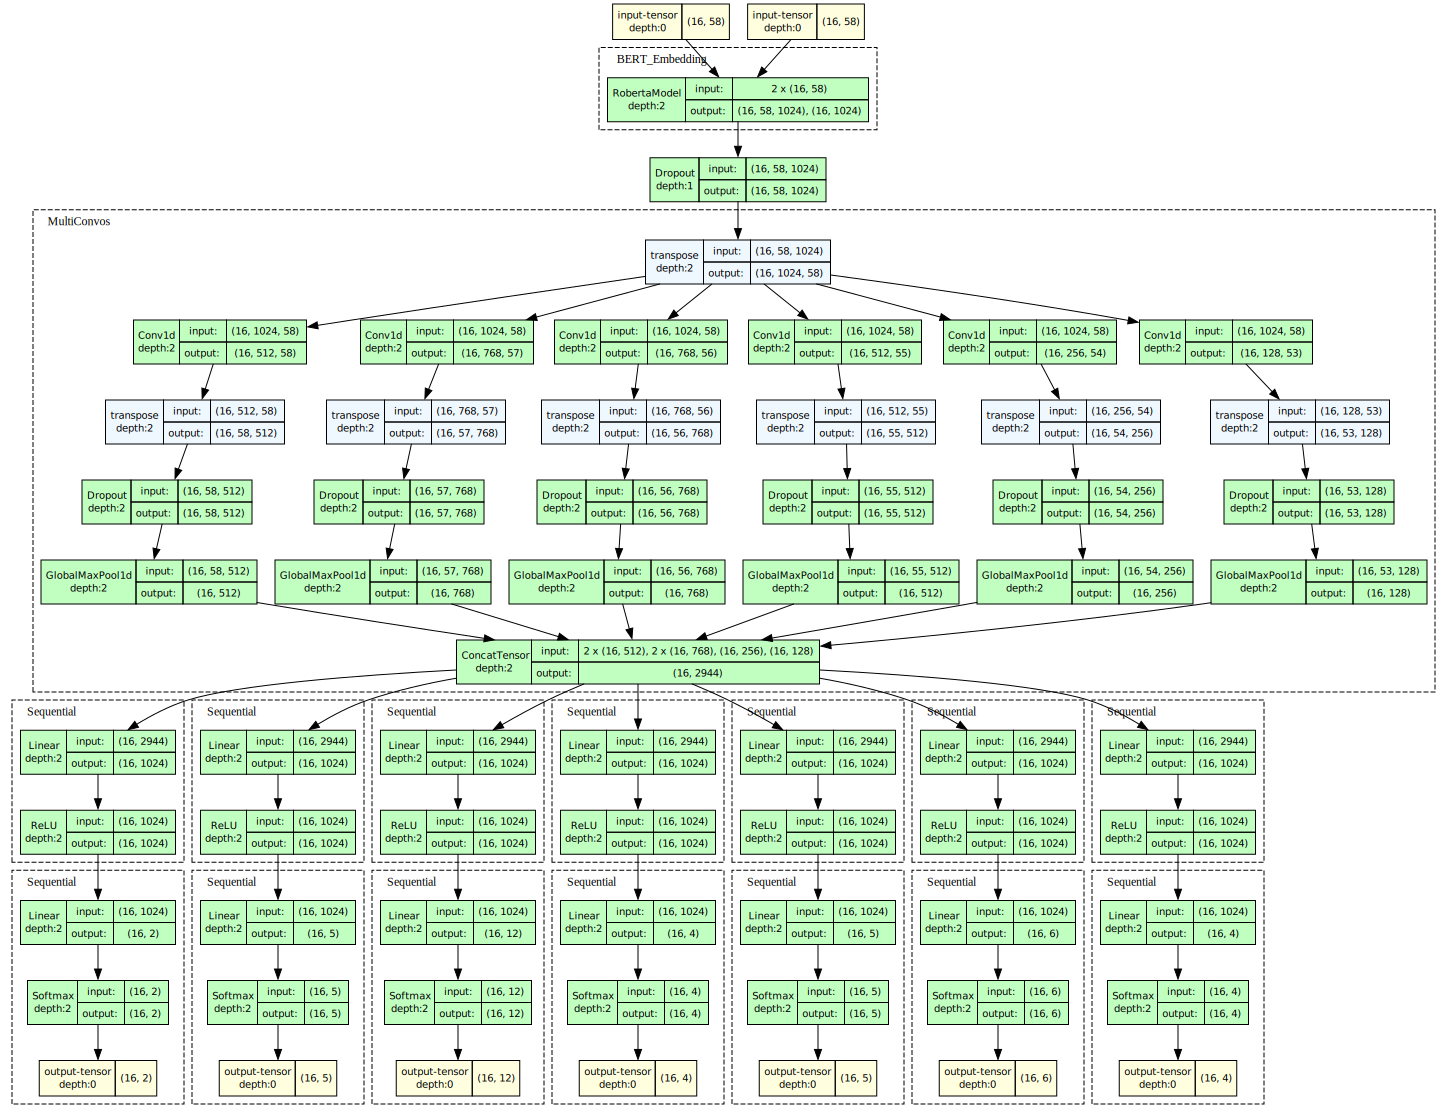

In [44]:
model_graph = draw_graph(model, 
                         input_data=(input_ids, attention_mask),
                         expand_nested=True,
                         depth=2)
model_graph.visual_graph

In [45]:
EPOCHS = 10

train_losses, train_f1s, dev_losses, dev_f1s = train_model(model,
                                                           train_loader,
                                                           dev_loader,
                                                           optimizer,
                                                           device,
                                                           classes_weights=CLASSES_WEIGHTS,
                                                           epochs=EPOCHS)

Epoch 1


100%|██████████| 875/875 [05:27<00:00,  2.67it/s]


Train loss: 8.73820
> Level 1: loss 0.64755, F1 0.46503
> Level 2: loss 1.25994, F1 0.38360
> Level 3: loss 1.97498, F1 0.34928
> Level 3_1: loss 1.09890, F1 0.45252
> Level 3_2: loss 1.26001, F1 0.38444
> Level 3_3: loss 1.39902, F1 0.40250
> Level 3_4: loss 1.09779, F1 0.45210


100%|██████████| 125/125 [00:14<00:00,  8.79it/s]


Dev loss: 10.57268
> Level 1: loss 0.66938, F1 0.48202
> Level 2: loss 1.57005, F1 0.36391
> Level 3: loss 2.45580, F1 0.32896
> Level 3_1: loss 1.33141, F1 0.45172
> Level 3_2: loss 1.53612, F1 0.36390
> Level 3_3: loss 1.73325, F1 0.38777
> Level 3_4: loss 1.27666, F1 0.44508

Epoch 2


100%|██████████| 875/875 [05:27<00:00,  2.67it/s]


Train loss: 8.75309
> Level 1: loss 0.66762, F1 0.49006
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.82it/s]


Dev loss: 10.54196
> Level 1: loss 0.66832, F1 0.48202
> Level 2: loss 1.57392, F1 0.36391
> Level 3: loss 2.45837, F1 0.32896
> Level 3_1: loss 1.29306, F1 0.45172
> Level 3_2: loss 1.54195, F1 0.36390
> Level 3_3: loss 1.73767, F1 0.38777
> Level 3_4: loss 1.26867, F1 0.44508

Epoch 3


100%|██████████| 875/875 [05:26<00:00,  2.68it/s]


Train loss: 8.75162
> Level 1: loss 0.66530, F1 0.48607
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09880, F1 0.45864
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09810, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.84it/s]


Dev loss: 11.62375
> Level 1: loss 0.67312, F1 0.48202
> Level 2: loss 1.73363, F1 0.04382
> Level 3: loss 2.53100, F1 0.02492
> Level 3_1: loss 1.53594, F1 0.00186
> Level 3_2: loss 1.75204, F1 0.02593
> Level 3_3: loss 1.91728, F1 0.00215
> Level 3_4: loss 1.48074, F1 0.00311

Epoch 4


100%|██████████| 875/875 [05:27<00:00,  2.67it/s]


Train loss: 8.75309
> Level 1: loss 0.66762, F1 0.49006
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.83it/s]


Dev loss: 11.62462
> Level 1: loss 0.67312, F1 0.48202
> Level 2: loss 1.73365, F1 0.04382
> Level 3: loss 2.53103, F1 0.02492
> Level 3_1: loss 1.53636, F1 0.00186
> Level 3_2: loss 1.75191, F1 0.02593
> Level 3_3: loss 1.91725, F1 0.00215
> Level 3_4: loss 1.48131, F1 0.00311

Epoch 5


100%|██████████| 875/875 [05:27<00:00,  2.67it/s]


Train loss: 8.75080
> Level 1: loss 0.66533, F1 0.48766
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.77it/s]


Dev loss: 11.62650
> Level 1: loss 0.67307, F1 0.48202
> Level 2: loss 1.73391, F1 0.01216
> Level 3: loss 2.53027, F1 0.02291
> Level 3_1: loss 1.51329, F1 0.00186
> Level 3_2: loss 1.74311, F1 0.02593
> Level 3_3: loss 1.89622, F1 0.02519
> Level 3_4: loss 1.53662, F1 0.00311

Epoch 6


100%|██████████| 875/875 [05:28<00:00,  2.66it/s]


Train loss: 8.75309
> Level 1: loss 0.66762, F1 0.49006
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


Dev loss: 11.61565
> Level 1: loss 0.67300, F1 0.48202
> Level 2: loss 1.73375, F1 0.01216
> Level 3: loss 2.53023, F1 0.02291
> Level 3_1: loss 1.50833, F1 0.00186
> Level 3_2: loss 1.74304, F1 0.02593
> Level 3_3: loss 1.89622, F1 0.02519
> Level 3_4: loss 1.53109, F1 0.00311

Epoch 7


100%|██████████| 875/875 [05:29<00:00,  2.66it/s]


Train loss: 8.75523
> Level 1: loss 0.66975, F1 0.48397
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]


Dev loss: 11.55122
> Level 1: loss 0.78179, F1 0.18793
> Level 2: loss 1.76347, F1 0.01216
> Level 3: loss 2.53014, F1 0.02492
> Level 3_1: loss 1.41512, F1 0.16176
> Level 3_2: loss 1.70546, F1 0.02593
> Level 3_3: loss 1.87597, F1 0.02519
> Level 3_4: loss 1.47925, F1 0.15591

Epoch 8


100%|██████████| 875/875 [05:29<00:00,  2.66it/s]


Train loss: 8.93495
> Level 1: loss 0.84948, F1 0.32001
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.67it/s]


Dev loss: 10.22711
> Level 1: loss 0.95340, F1 0.18793
> Level 2: loss 1.50076, F1 0.36391
> Level 3: loss 2.34989, F1 0.32896
> Level 3_1: loss 1.14933, F1 0.45172
> Level 3_2: loss 1.48948, F1 0.36390
> Level 3_3: loss 1.63577, F1 0.38777
> Level 3_4: loss 1.14847, F1 0.44508

Epoch 9


100%|██████████| 875/875 [05:29<00:00,  2.66it/s]


Train loss: 9.04437
> Level 1: loss 0.95890, F1 0.19146
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.69it/s]


Dev loss: 10.22711
> Level 1: loss 0.95340, F1 0.18793
> Level 2: loss 1.50076, F1 0.36391
> Level 3: loss 2.34989, F1 0.32896
> Level 3_1: loss 1.14933, F1 0.45172
> Level 3_2: loss 1.48948, F1 0.36390
> Level 3_3: loss 1.63577, F1 0.38777
> Level 3_4: loss 1.14847, F1 0.44508

Epoch 10


100%|██████████| 875/875 [05:29<00:00,  2.66it/s]


Train loss: 9.04437
> Level 1: loss 0.95890, F1 0.19146
> Level 2: loss 1.25919, F1 0.38384
> Level 3: loss 1.97309, F1 0.34962
> Level 3_1: loss 1.09803, F1 0.45959
> Level 3_2: loss 1.25919, F1 0.38444
> Level 3_3: loss 1.39795, F1 0.40280
> Level 3_4: loss 1.09803, F1 0.45669


100%|██████████| 125/125 [00:14<00:00,  8.68it/s]

Dev loss: 10.22711
> Level 1: loss 0.95340, F1 0.18793
> Level 2: loss 1.50076, F1 0.36391
> Level 3: loss 2.34989, F1 0.32896
> Level 3_1: loss 1.14933, F1 0.45172
> Level 3_2: loss 1.48948, F1 0.36390
> Level 3_3: loss 1.63577, F1 0.38777
> Level 3_4: loss 1.14847, F1 0.44508



### Plotting

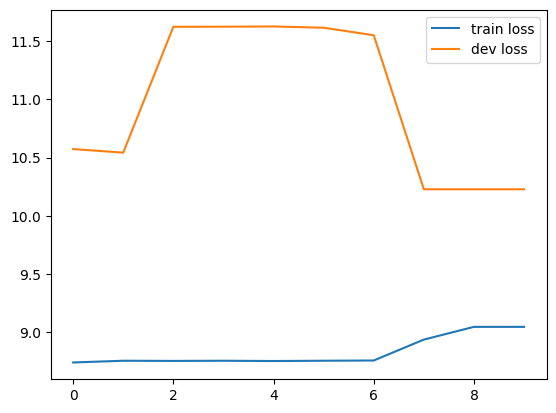

In [46]:
import matplotlib.pyplot as plt

# losses

plt.plot(train_losses, label='train loss')
plt.plot(dev_losses, label='dev loss')
plt.legend()
plt.show()

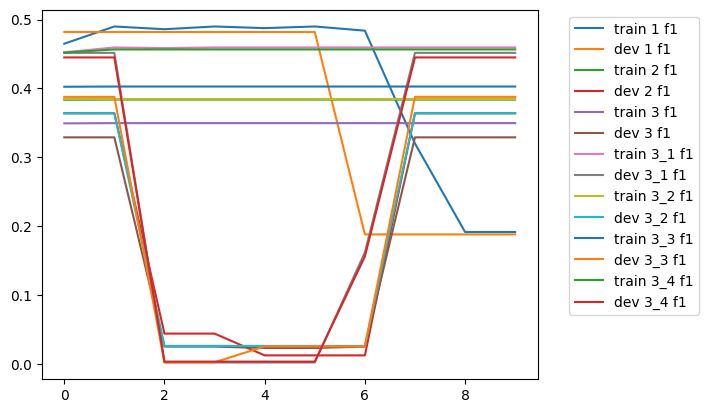

In [47]:
# f1s
f1_levels_train = []
f1_levels_dev = []
for i in range(len(LEVELS)):
    f1_levels_train.append([f1[i].item() for f1 in train_f1s])
    f1_levels_dev.append([f1[i].item() for f1 in dev_f1s])

for i in range(len(LEVELS)):
    plt.plot(f1_levels_train[i], label=f'train {LEVELS[i]} f1')
    plt.plot(f1_levels_dev[i], label=f'dev {LEVELS[i]} f1')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## **Predict**

In [48]:
torch.cuda.empty_cache()

In [49]:
test_preds = [[], [], [], [], [], [], []]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        logits = model(input_ids, attention_mask)
        for i in range(len(LEVELS)):
            test_preds[i].extend(torch.argmax(logits[i], dim=1).tolist())

test_preds = torch.tensor(test_preds)
test_preds.shape

100%|██████████| 250/250 [00:27<00:00,  9.03it/s]


torch.Size([7, 4000])

In [50]:
test_labels = []
for i in range(len(LEVELS)):
    test_labels.append(torch.argmax(y_tests[i], dim=1).tolist())

test_labels = torch.tensor(test_labels)
test_labels.shape

torch.Size([7, 4000])

In [51]:
for i in range(len(LEVELS)):
    test[f'pred_{LEVELS[i]}'] = [idx_to_label(idx, i+1) for idx in test_preds[i].tolist()]

test.to_csv(f'./{model_name}_test_preds.csv', index=False)
test.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens,pred_1,pred_2,pred_3,pred_3_1,pred_3_2,pred_3_3,pred_3_4
0,sexism2022_english-845,Fuck the niggers and the jews. Both have a his...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,fuck the niggers and the jews . both have a hi...,sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
1,sexism2022_english-6629,Well then good because someone has to knock he...,sexist,2. derogation,2.2 aggressive and emotive attacks,other,2.2 aggressive and emotive attacks,other,other,well then good because someone has to knock he...,sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
2,sexism2022_english-17573,#USA #Texas #Islam #Muslims #Islamization #Sha...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,# usa # texas # islam # muslims # islamization...,sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
3,sexism2022_english-10268,"Yes, normal women want to be dominated. Social...",sexist,2. derogation,2.1 descriptive attacks,other,2.1 descriptive attacks,other,other,"yes , normal women want to be dominated . soci...",sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
4,sexism2022_english-10735,She didn't have to be a bitch about it. She li...,sexist,2. derogation,2.2 aggressive and emotive attacks,other,2.2 aggressive and emotive attacks,other,other,she didn't have to be a bitch about it . she l...,sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist


In [52]:

def get_report(preds, labels):
    reports = []
    for i in range(len(LEVELS)):
        print(f'Level {LEVELS[i]}')
        # print('Labels:', labels[i].shape, 'Preds:', preds[i].shape)
        reports.append(classification_report(labels[i], preds[i], target_names=ALL_LABELS[i], digits=4, output_dict=True))
        print(classification_report(labels[i], preds[i], target_names=ALL_LABELS[i], digits=4))
    return reports

test_reports = get_report(test_preds, test_labels)
# print(test_reports, sep='\n')

Level 1
              precision    recall  f1-score   support

  not sexist     0.0000    0.0000    0.0000      3030
      sexist     0.2425    1.0000    0.3903       970

    accuracy                         0.2425      4000
   macro avg     0.1212    0.5000    0.1952      4000
weighted avg     0.0588    0.2425    0.0947      4000

Level 2
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.0000    0.0000    0.0000        89
                           2. derogation     0.0000    0.0000    0.0000       454
                            3. animosity     0.0000    0.0000    0.0000       333
               4. prejudiced discussions     0.0000    0.0000    0.0000        94
                              not sexist     0.7575    1.0000    0.8620      3030

                                accuracy                         0.7575      4000
                               macro avg     0.1515    0.2000    0.1724      4000